In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd
import pickle

In [2]:
# pip install wordcloud

In [3]:
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
# from imblearn.over_sampling import SMOTE
# import plotly.express as px
import warnings

In [4]:
data = pd.read_csv('mbti_1.csv')

In [5]:
data.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

<ipython-input-6-c4d51ae7f98d>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)


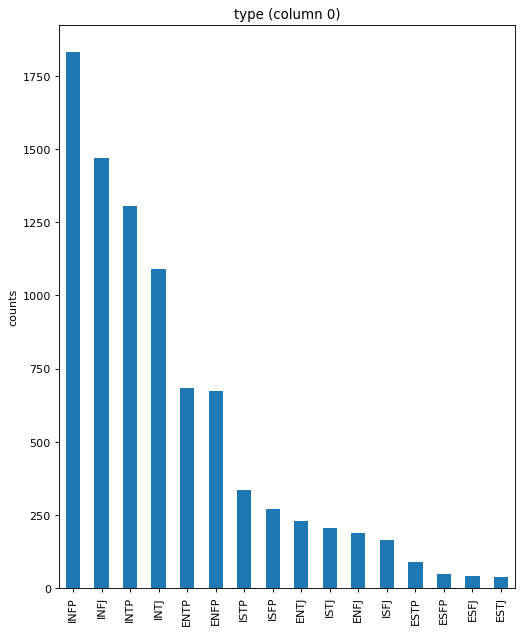

In [7]:
plotPerColumnDistribution(data, 10, 5)

In [8]:
data.describe(include='O')

,type,posts
count,8675,8675
unique,16,8675
top,INFP,"'I'd learn Latin, get vaccinated for smallpox,..."
freq,1832,1


In [9]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [11]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [12]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

In [13]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [14]:
train_data.posts,train_length=clear_text(train_data)

100%|████████████████████████████████████████████████████████████████████████████| 6940/6940 [00:03<00:00, 1829.30it/s]
C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
test_data.posts,test_length=clear_text(test_data)

100%|████████████████████████████████████████████████████████████████████████████| 1735/1735 [00:00<00:00, 1754.05it/s]


C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


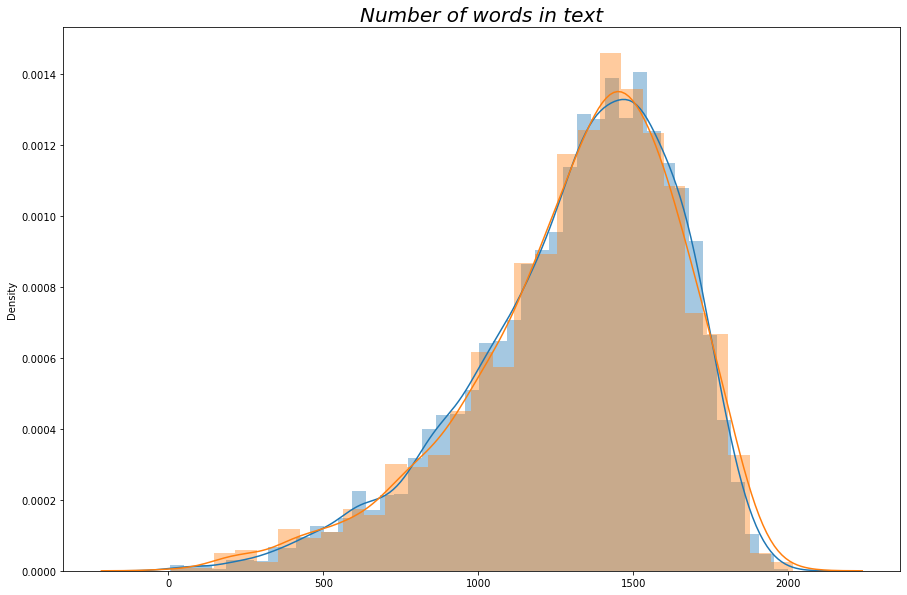

In [16]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [17]:
# import nltk
# nltk.download()

In [18]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [19]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x0000018EE4036430>)

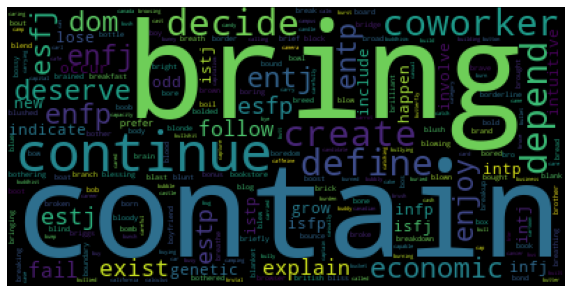

In [20]:
feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(10,7))
plt.axis('off')
plt.imshow(wc)

In [21]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [22]:
train_data.shape

(6940, 2)

In [23]:
train_post.shape

(6940, 5000)

In [24]:
train_post

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06447606, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03124385, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05058323, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [25]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

In [26]:
pickle.dump(target_encoder, open("target_encoder.pkl", 'wb'))

In [27]:
models_accuracy={}

# Logistic Regression

In [28]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [29]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.86      0.16      0.27       152
        ENFP       0.81      0.65      0.72       540
        ENTJ       0.93      0.29      0.44       185
        ENTP       0.82      0.66      0.73       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.73      0.83      0.78      1176
        INFP       0.66      0.93      0.77      1465
        INTJ       0.73      0.80      0.77       873
        INTP       0.69      0.87      0.77      1043
        ISFJ       0.89      0.24      0.38       133
        ISFP       0.86      0.26      0.40       217
        ISTJ       0.86      0.27      0.41       164
        ISTP       0.86      0.52      0.65       270

    accuracy                           0.72      

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:

print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       1.00      0.08      0.15        38
        ENFP       0.76      0.53      0.62       135
        ENTJ       0.75      0.13      0.22        46
        ENTP       0.66      0.51      0.58       137
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.64      0.71      0.67       294
        INFP       0.57      0.88      0.69       367
        INTJ       0.61      0.65      0.63       218
        INTP       0.66      0.83      0.74       261
        ISFJ       0.67      0.12      0.21        33
        ISFP       0.85      0.20      0.33        54
        ISTJ       0.60      0.07      0.13        41
        ISTP       0.68      0.45      0.54        67

    accuracy                           0.63      17

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

In [32]:
models_accuracy['logistic regression']

0.6282420749279539

In [33]:
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))

In [34]:
train_data.head()

,type,posts
1228,INFP,we are mandarin speakers he receive educati...
1290,ISTP,nope not now not ever i m too busy with ...
6756,ENFJ,that s the only one i haven t gotten to read ...
1662,INFP,i used to think that maturity was burning bri...
3338,INFP,i get typed as both a 4w5 and 5w6 as well but...


In [35]:
train_data.posts[1:2]


1290     nope   not now  not ever   i m too busy with ...
Name: posts, dtype: object

In [36]:
train_post1=vectorizer.transform(train_data.posts[1:2]).toarray()
train_post1

array([[0.        , 0.        , 0.06447606, ..., 0.        , 0.        ,
        0.        ]])

In [37]:
train_post1.shape

(1, 5000)

In [38]:
model_log.predict(train_post1)

array([15])

In [39]:
op=model_log.predict(train_post1)
target_names=target_encoder.inverse_transform(op)
target_names

array(['ISTP'], dtype=object)

In [40]:
pickle.dump(model_log, open("log_model", 'wb'))

# XGBoost Classifier

In [41]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb.fit(train_post,train_target)

[15:20:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: [15:20:54] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.

In [ ]:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))
models_accuracy['XGBoost Classifier']